In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from pathlib import Path

from pipeline.features import get_merged_df, merge_segment_dfs
from pipeline import models, validation

base_path = Path('../../own_data/191104_depr_splits_features/')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
feature_methods = [
    'env-alpha',
    'env-beta',
    'coh-alpha',
    'coh-beta',
    'bands'
]


In [4]:
model = models.LRScaled()

In [5]:
def plot_hist(scores, bins=None):
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    accs = np.array([score.acc for score in scores])
    roc_aucs = np.array([score.roc_auc for score in scores])
    axes[0].set_title('accuracy')
    axes[1].set_title('roc-auc')
    for ax, values in zip(axes, (accs, roc_aucs)):
        _, bin_ticks, _ = ax.hist(values, bins=bins)
        ax.set_xticks(bin_ticks)
        ax.grid()
        ax.legend([f"mean={values.mean():4f}, std={values.std():4f}"], loc='lower center')


# Вложенная кросс-валидация

In [6]:
dir_60 = '60s_1_0_60'
df_60 = get_merged_df(base_path/dir_60, feature_methods)
features = list(df_60.columns.difference(['fn', 'target']))
df_60

,env_alpha_t6_t4,env_alpha_t6_o1,env_alpha_t6_f8,env_alpha_t6_p4,env_alpha_t6_c4,env_alpha_t6_t3,env_alpha_t6_f7,env_alpha_t6_f3,env_alpha_t6_o2,env_alpha_t6_f4,...,bands_theta_fp2,bands_gamma_fp2,bands_alpha_pz,bands_beta_pz,bands_theta_pz,bands_gamma_pz,bands_alpha_fz,bands_beta_fz,bands_theta_fz,bands_gamma_fz
0,0.917697,0.563511,0.733981,0.890499,0.632585,0.608995,0.587589,0.465903,0.805666,0.609705,...,76.762404,223.139269,117.150068,164.755453,35.463277,28.187124,98.343289,108.277046,37.334738,28.722190
1,0.565322,0.691463,0.395560,0.838802,0.390735,0.262696,0.187657,0.332430,0.890252,0.320593,...,109.031106,40.317846,1392.374420,1108.730184,158.650258,16.762985,84.285868,84.302854,46.954869,8.226627
2,0.629710,0.742584,0.337813,0.933791,0.425255,0.341252,0.330948,0.397619,0.893039,0.341289,...,109.676682,37.244491,396.212235,16737.199176,92.482670,23.688684,62.222036,55.340857,66.968057,12.229815
3,0.392081,0.721059,-0.166488,0.952961,-0.179521,-0.013503,-0.138383,0.019072,0.899326,0.062211,...,242.284662,61.902771,1402.297460,5319.573022,499.475399,39.080631,1370.389841,133.779096,157.880979,26.377877
4,0.516039,0.187451,0.147631,0.667217,0.212268,-0.072102,-0.042938,-0.026311,0.445761,0.034387,...,79.849897,38.397270,44.429980,3056.271978,8.272703,4.270951,583.029084,1622.924687,59.905467,17.054516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.320649,0.460332,0.275037,0.832568,0.209685,0.150084,0.175227,0.049109,0.323179,0.044881,...,109.871639,84.936083,78.607109,120.082482,57.963587,33.750995,57.562769,130.190187,70.153724,39.362271
85,0.506808,0.584114,0.188425,0.822727,0.245671,0.085810,0.114380,0.109895,0.844802,0.114598,...,68.956414,490.521475,59.513111,234.329094,13.899956,20.127859,49.884187,95.962272,13.146620,27.750833
86,0.259040,0.566986,0.131429,0.840699,0.625840,0.283663,0.111872,0.153800,0.817723,-0.000478,...,75.843012,38.345946,141.290909,109.746711,51.717088,8.147933,69.507591,52.825597,42.773493,17.579949
87,0.815288,0.426830,0.469146,0.886377,0.645449,0.436458,0.283878,0.097605,0.813297,0.139836,...,187.146779,53.912354,684.965572,431.805932,272.631981,12.435821,348.631879,681.603079,199.181942,26.095614


In [12]:
scores = validation.nested_cross_val(df_60, features, model, random_state=57, p_bar=1)

In [13]:
scores.roc_auc

0.7232323232323233

# Проверка признаков на отложенной выборке

In [14]:
scores = validation.get_repeated_scores(validation.train_test_val, df_60, features, model, random_state=57, n_repeats=50, p_bar=0)

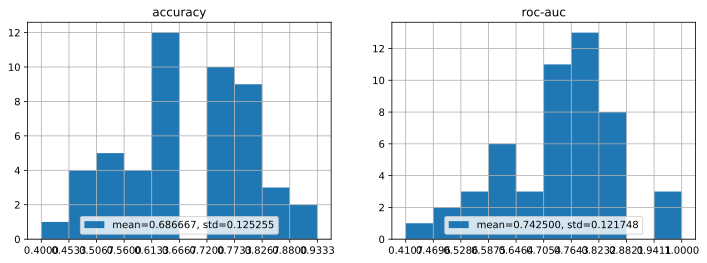

In [15]:
plot_hist(scores)

In [16]:
scores = validation.get_repeated_scores(validation.train_test_val, df_60, features, model, random_state=57, n_repeats=1000, p_bar=1)

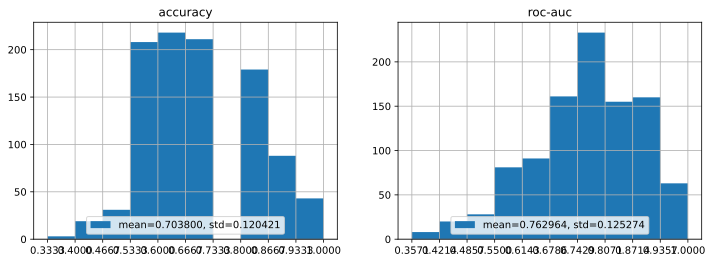

In [17]:
plot_hist(scores)

## Проверка качества на разных временных промежутках

In [18]:
dir_10 = '10s_1_0_10'
dir_20 = '20s_1_20_40'
dir_30 = '30s_0_30_60'
df_10 = get_merged_df(base_path/dir_10, feature_methods)
df_20 = get_merged_df(base_path/dir_20, feature_methods)
df_30 = get_merged_df(base_path/dir_30, feature_methods)

In [19]:
scores_10 = validation.get_repeated_scores(validation.train_test_val, df_10, features, model, random_state=57, n_repeats=100, p_bar=1)
scores_20 = validation.get_repeated_scores(validation.train_test_val, df_20, features, model, random_state=58, n_repeats=100, p_bar=1)
scores_30 = validation.get_repeated_scores(validation.train_test_val, df_30, features, model, random_state=59, n_repeats=100, p_bar=1)

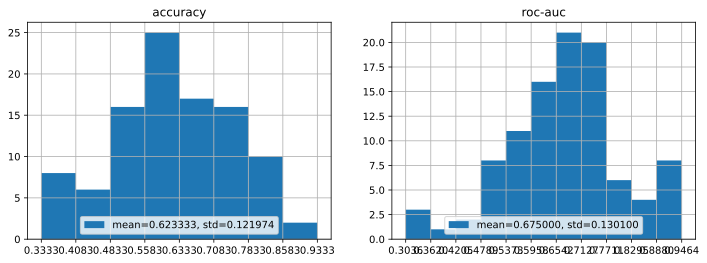

In [20]:
plot_hist(scores_10, bins='auto')

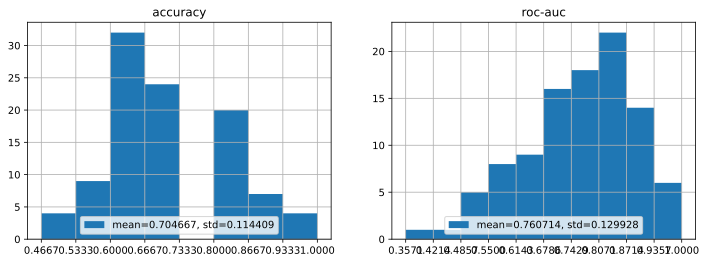

In [21]:
plot_hist(scores_20, bins='auto')

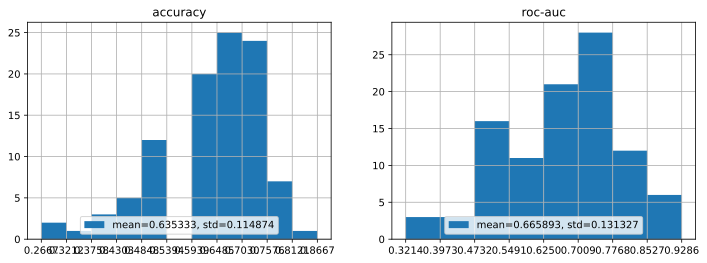

In [22]:
plot_hist(scores_30, bins='auto')

# Расширение выборки данными с разных сегментов

Наилучший результат достигается при использовании более длинных промежутков.

## Сегменты по 10 секунд

In [23]:
dirs = ('10s_1_0_10', '10s_1_10_20', '10s_1_20_30', '10s_1_30_40', '10s_1_40_50', '10s_1_50_60')
dfs = [get_merged_df(base_path/dir, feature_methods) for dir in dirs]
df_combined = merge_segment_dfs(dfs)
df_combined

,env_alpha_t6_t4,env_alpha_t6_o1,env_alpha_t6_f8,env_alpha_t6_p4,env_alpha_t6_c4,env_alpha_t6_t3,env_alpha_t6_f7,env_alpha_t6_f3,env_alpha_t6_o2,env_alpha_t6_f4,...,bands_gamma_fp2,bands_alpha_pz,bands_beta_pz,bands_theta_pz,bands_gamma_pz,bands_alpha_fz,bands_beta_fz,bands_theta_fz,bands_gamma_fz,segment_id
0,0.914285,0.695979,0.724699,0.890229,0.551959,0.670720,0.611987,0.535454,0.764269,0.498697,...,251.486923,133.922427,112.963701,20.737254,25.441610,32.561270,61.582367,40.861963,21.764552,0
1,0.586656,0.563749,0.261684,0.823794,0.346171,-0.013657,-0.110797,0.179467,0.848123,0.095687,...,37.909243,723.331197,1016.607728,70.421929,19.077140,24.123943,69.312584,32.058691,7.771738,0
2,0.457119,0.456332,0.441248,0.722768,0.389885,0.233648,0.135644,-0.053469,0.561689,0.368402,...,60.237380,70.063345,22706.960920,71.822150,20.492636,21.316349,54.745767,86.837347,15.404566,0
3,0.582743,0.704017,-0.065206,0.969298,-0.125681,0.080891,0.093202,0.235169,0.887544,0.110030,...,114.734900,1290.664552,10159.584699,1032.345907,46.425218,368.043076,88.511667,47.185276,42.632577,0
4,0.370072,0.331238,0.150465,0.647416,0.222495,-0.058686,0.078606,0.154638,0.569723,0.233763,...,30.731451,47.920225,5447.790909,13.471301,7.778474,622.034332,2575.071792,71.042945,15.754958,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,0.312314,0.487702,0.336305,0.851390,0.221079,0.120738,0.079060,-0.051852,0.693881,0.041423,...,78.765954,53.776881,145.567260,59.104417,34.647162,41.839973,135.205323,57.478750,39.792874,5
530,0.237181,0.604889,-0.056222,0.796394,0.009880,0.162277,0.165035,0.054907,0.815130,-0.022121,...,317.057262,52.300108,374.989796,4.815677,20.698512,32.543488,141.724230,12.574732,28.478222,5
531,0.142793,0.633893,0.086678,0.846117,0.620504,0.400371,0.156858,0.144730,0.817416,0.058072,...,38.580552,115.638305,137.027824,36.492265,7.572335,67.398890,46.971191,39.557153,13.050555,5
532,0.878237,0.392614,0.451882,0.903655,0.649734,0.307619,0.160375,0.006918,0.857550,-0.015248,...,43.197215,582.728403,456.280198,260.092579,9.620329,334.805341,547.120642,223.483072,18.052830,5


In [24]:
scores = validation.get_repeated_scores(validation.multi_segment_train_test, df_combined, features, model, random_state=57, n_repeats=100, p_bar=1)

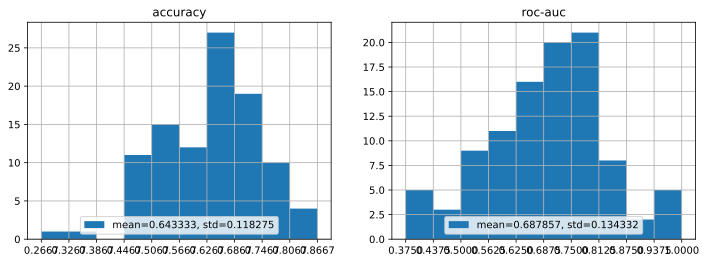

In [25]:
plot_hist(scores)

## Сегменты по 20 секунд

In [26]:
dirs = ('20s_1_0_20', '20s_1_20_40', '20s_1_40_60')
dfs = [get_merged_df(base_path/dir, feature_methods) for dir in dirs]

In [27]:
df_combined = merge_segment_dfs(dfs)
df_combined

,env_alpha_t6_t4,env_alpha_t6_o1,env_alpha_t6_f8,env_alpha_t6_p4,env_alpha_t6_c4,env_alpha_t6_t3,env_alpha_t6_f7,env_alpha_t6_f3,env_alpha_t6_o2,env_alpha_t6_f4,...,bands_gamma_fp2,bands_alpha_pz,bands_beta_pz,bands_theta_pz,bands_gamma_pz,bands_alpha_fz,bands_beta_fz,bands_theta_fz,bands_gamma_fz,segment_id
0,0.903212,0.668728,0.712176,0.897785,0.649626,0.677085,0.622003,0.504900,0.813267,0.633535,...,216.472992,122.871938,120.667373,34.256358,30.320214,62.591809,80.102953,43.232044,23.353978,0
1,0.455296,0.657557,0.225202,0.762450,0.296469,0.081164,-0.058821,0.112804,0.836720,0.101374,...,39.974496,465.851508,1045.326646,61.569659,16.625218,20.474018,65.604699,33.818140,7.830952,0
2,0.664440,0.713398,0.317772,0.942866,0.486986,0.341628,0.301291,0.310080,0.895424,0.254037,...,43.430587,118.274440,20173.276035,63.086443,24.293716,26.275673,60.054318,70.261342,13.745484,0
3,0.516754,0.784223,-0.281923,0.966653,-0.277566,-0.017970,-0.214442,-0.064275,0.922058,-0.022477,...,94.779284,1378.504194,8182.549637,932.528923,42.828699,788.254969,109.130366,102.240952,35.426058,0
4,0.338863,0.238128,0.076255,0.609050,0.146275,-0.035710,-0.001626,0.039533,0.425670,0.059878,...,33.714367,57.037651,4184.774655,10.248663,6.064255,744.766390,2259.690669,87.405138,16.506437,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0.353909,0.450373,0.284153,0.845154,0.192295,0.185421,0.185592,0.048412,0.352170,0.119940,...,56.846150,66.915658,110.791899,62.764702,27.586719,68.232528,125.529162,65.547071,29.699432,2
263,0.405750,0.443676,-0.052183,0.785898,0.205441,-0.002874,-0.071132,-0.051847,0.804471,0.011939,...,400.696032,57.041019,216.128536,11.770267,20.825571,38.327482,97.971055,11.547572,24.951028,2
264,0.046665,0.655266,-0.004629,0.840410,0.594159,0.379012,0.178795,0.128452,0.826832,-0.035163,...,37.286965,170.126277,133.385000,47.406128,7.894467,85.407367,54.675545,42.224198,17.357731,2
265,0.822209,0.477668,0.434700,0.891781,0.674885,0.368518,0.184517,0.057977,0.832794,0.051860,...,53.542744,708.798341,446.211338,234.148504,11.564911,273.306772,584.035251,177.031113,24.771321,2


In [28]:
scores = validation.get_repeated_scores(validation.multi_segment_train_test, df_combined, features, model, random_state=57, n_repeats=100, p_bar=1)

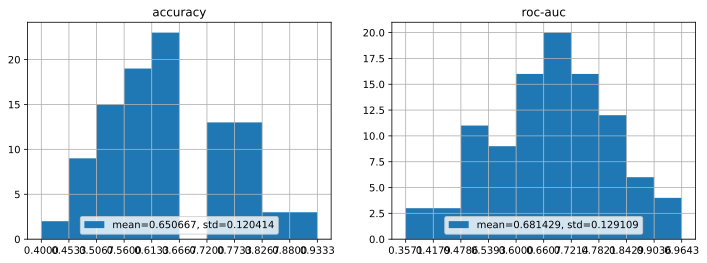

In [29]:
plot_hist(scores)

## Сегмент 60 секунд + сегменты по 30 секунд

In [7]:
dirs = ('60s_1_0_60', '30s_1_0_30', '30s_1_30_60')
dfs = [get_merged_df(base_path/dir, feature_methods) for dir in dirs]

In [8]:
df_combined = merge_segment_dfs(dfs)
df_combined

,env_alpha_t6_t4,env_alpha_t6_o1,env_alpha_t6_f8,env_alpha_t6_p4,env_alpha_t6_c4,env_alpha_t6_t3,env_alpha_t6_f7,env_alpha_t6_f3,env_alpha_t6_o2,env_alpha_t6_f4,...,bands_gamma_fp2,bands_alpha_pz,bands_beta_pz,bands_theta_pz,bands_gamma_pz,bands_alpha_fz,bands_beta_fz,bands_theta_fz,bands_gamma_fz,segment_id
0,0.917697,0.563511,0.733981,0.890499,0.632585,0.608995,0.587589,0.465903,0.805666,0.609705,...,223.139269,117.150068,164.755453,35.463277,28.187124,98.343289,108.277046,37.334738,28.722190,0
1,0.565322,0.691463,0.395560,0.838802,0.390735,0.262696,0.187657,0.332430,0.890252,0.320593,...,40.317846,1392.374420,1108.730184,158.650258,16.762985,84.285868,84.302854,46.954869,8.226627,0
2,0.629710,0.742584,0.337813,0.933791,0.425255,0.341252,0.330948,0.397619,0.893039,0.341289,...,37.244491,396.212235,16737.199176,92.482670,23.688684,62.222036,55.340857,66.968057,12.229815,0
3,0.392081,0.721059,-0.166488,0.952961,-0.179521,-0.013503,-0.138383,0.019072,0.899326,0.062211,...,61.902771,1402.297460,5319.573022,499.475399,39.080631,1370.389841,133.779096,157.880979,26.377877,0
4,0.516039,0.187451,0.147631,0.667217,0.212268,-0.072102,-0.042938,-0.026311,0.445761,0.034387,...,38.397270,44.429980,3056.271978,8.272703,4.270951,583.029084,1622.924687,59.905467,17.054516,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0.322791,0.454945,0.269073,0.838192,0.169618,0.198110,0.186271,0.050405,0.403630,0.075795,...,67.951691,72.362471,116.961489,62.921565,29.547401,58.361786,129.697972,64.945116,33.648098,2
263,0.465183,0.539167,0.086852,0.808753,0.250496,-0.040616,0.037373,0.076914,0.826408,0.063804,...,414.614072,66.609894,266.311316,12.838684,20.264966,54.028860,98.795621,12.471480,24.462345,2
264,0.153454,0.567152,0.058962,0.852240,0.626361,0.289296,0.119316,0.198035,0.824322,-0.022799,...,39.624121,144.453318,133.613429,47.433091,8.561120,72.903758,52.527177,41.581087,17.720611,2
265,0.802197,0.477024,0.427337,0.868348,0.620268,0.407511,0.228470,0.049710,0.798411,0.068738,...,52.054909,685.477156,440.041881,314.731151,11.598080,333.589377,636.297019,245.954735,24.344088,2


In [13]:
scores = validation.get_repeated_scores(validation.multi_segment_train_test, df_combined, features, model, random_state=57, n_repeats=100, p_bar=1)

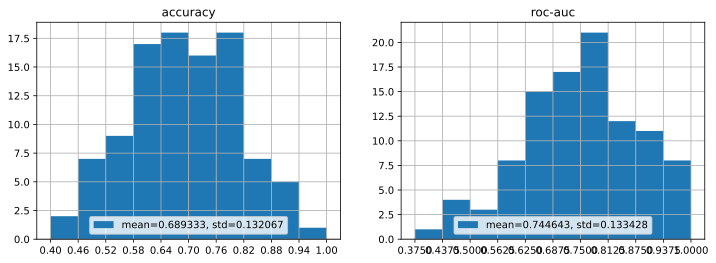

In [14]:
plot_hist(scores)

## Изменение размера тестовой выборки

In [10]:
scores = validation.get_repeated_scores(validation.train_test_val, df_60, features, model, random_state=57, method_kwargs={'test_size':30}, n_repeats=100, p_bar=1)

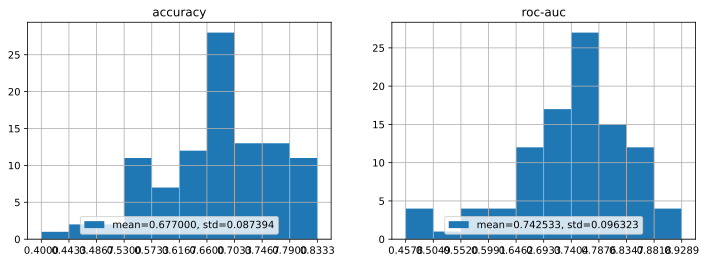

In [11]:
plot_hist(scores)

In [9]:
scores = validation.get_repeated_scores(validation.multi_segment_train_test, df_combined, features, model, random_state=57, method_kwargs={'test_size':30}, n_repeats=100, p_bar=1)

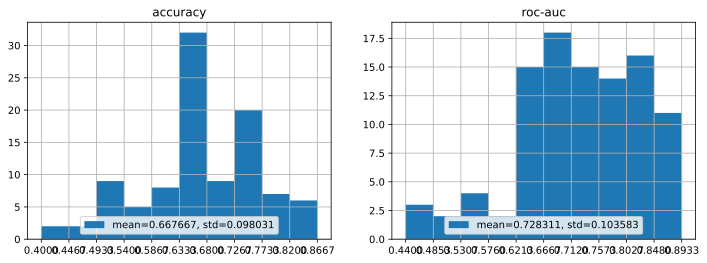

In [10]:
plot_hist(scores)

# Оптимизация accuracy при отборе признаков

Оптимизация accuracy не даёт прироста качества.

In [11]:
scores = validation.get_repeated_scores(validation.train_test_val, df_60, features, model, random_state=57, n_repeats=500, p_bar=1, method_kwargs={'metric': 'acc'})

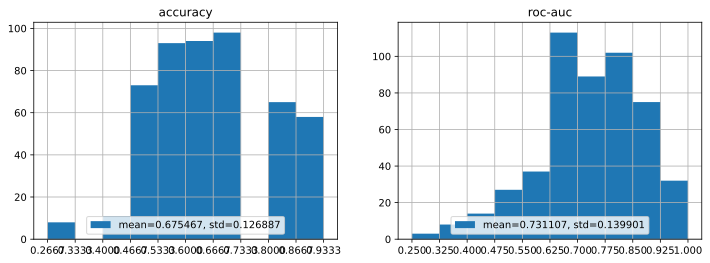

In [12]:
plot_hist(scores)